<a href="https://colab.research.google.com/github/fallensoapbubble/EEG/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load all CSV files from the Google Drive folder

- https://drive.google.com/drive/folders/18MROKCFAXhI1rDUcETPeEfN4erD8SuJ1

- https://drive.google.com/drive/folders/1BmEK2zg-tz4tF8O715ahwzFSrS_4feTE

## List files in the specified folder



In [ ]:
from google.colab import auth
from googleapiclient.discovery import build

auth.authenticate_user()

In [ ]:
folder_id = '18MROKCFAXhI1rDUcETPeEfN4erD8SuJ1'
service = build('drive', 'v3')

results = service.files().list(
    q=f"'{folder_id}' in parents",
    fields="files(id, name)").execute()
files = results.get('files', [])

if not files:
    print('No files found.')
else:
    print('Files:')
    for file in files:
        print(f"{file.get('name')} ({file.get('id')})")

## Filter for csv files

### Subtask:
Modify the code to specifically filter the listed files to identify only the CSV files.


**Reasoning**:
Iterate through the list of files and filter for those with a '.csv' extension.



In [ ]:
csv_files = [file for file in files if file.get('name', '').lower().endswith('.csv')]

if not csv_files:
    print('No CSV files found.')
else:
    print('CSV Files:')
    for file in csv_files:
        print(f"{file.get('name')} ({file.get('id')})")

## Load csv files

### Subtask:
Generate code to load each identified CSV file into a pandas DataFrame or a list of DataFrames.


**Reasoning**:
Generate code to load each identified CSV file into a pandas DataFrame or a list of DataFrames.



In [ ]:
import io
import pandas as pd
from googleapiclient.http import MediaIoBaseDownload

dataframes = {}
for file in csv_files:
  file_id = file['id']
  file_name = file['name']
  request = service.files().get_media(fileId=file_id)
  fh = io.BytesIO()
  downloader = MediaIoBaseDownload(fh, request)
  done = False
  while done is False:
    status, done = downloader.next_chunk()
    print(f"Download {int(status.progress() * 100)}%.")
  fh.seek(0)
  df = pd.read_csv(fh)
  dataframes[file_name] = df
  print(f"Loaded {file_name} into a DataFrame.")

print("All CSV files loaded into dataframes dictionary.")

In [ ]:
dataframes.keys()

#Data cleaning:

#####Below code block removes all the irrelevant records before stimuli phase giving us only relevant data in the dataframes

In [ ]:
for name, df in dataframes.items():
    # Ensure column exists
    if "marker_label__desc" not in df.columns:
        print(f"{name}: Column 'marker_label__desc' not found — skipped.")
        continue

    # Find index of first row where 'active_period' appears anywhere in the string
    mask = df["marker_label__desc"].astype(str).str.contains("active_period", case=False, na=False)
    idx_list = df.index[mask].tolist()

    if idx_list:
        first_active_idx = idx_list[0]
        df = df.loc[first_active_idx:].reset_index(drop=True)
        dataframes[name] = df
        print(f"{name}: Trimmed from row {first_active_idx}, new shape = {df.shape}")
    else:
        print(f"{name}: No occurrence of 'active_period' found — left unchanged.")


# Access the files pls make copy while you work do not edit abv code!!!

---

# EDA

In [ ]:
for name, df in dataframes.items():
    print(f"--- DataFrame: {name} ---")
    display(df.head())
    df.info()
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\n")

## Summarize dataframes

In [ ]:
for name, df in dataframes.items():
    print(f"--- Descriptive Statistics for DataFrame: {name} ---")
    display(df.describe())

    print(f"\n--- Value Counts for Categorical Columns in DataFrame: {name} ---")
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"\nValue Counts for Column: {col}")
            display(df[col].value_counts())
    print("\n")

## Visualize data


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose key numerical columns
numerical_cols = ['eeg.af3_4_8Hz__feat', 'eeg.f7_4_8Hz__feat', 'latency_f__desc']

# Choose key categorical columns
categorical_cols = ['marker_label__desc', 'phase_name__desc']

# Histograms for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    for name, df in dataframes.items():
        sns.histplot(df[col].dropna(), kde=True, label=name, alpha=0.5)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Bar plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    for name, df in dataframes.items():
        if col in df.columns:
            df[col].value_counts().plot(kind='bar', alpha=0.7, label=name)
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Scatter plots for relationships between numerical variables (example with one dataframe)
if dataframes:
    first_df_name = list(dataframes.keys())[0]
    first_df = dataframes[first_df_name]

    # Example scatter plots
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=first_df, x='latency_f__desc', y='eeg.af3_4_8Hz__feat')
    plt.title(f'Scatter Plot of Latency vs EEG AF3 (4-8Hz) in {first_df_name}')
    plt.xlabel('latency_f__desc')
    plt.ylabel('eeg.af3_4_8Hz__feat')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=first_df, x='latency_f__desc', y='eeg.f7_4_8Hz__feat')
    plt.title(f'Scatter Plot of Latency vs EEG F7 (4-8Hz) in {first_df_name}')
    plt.xlabel('latency_f__desc')
    plt.ylabel('eeg.f7_4_8Hz__feat')
    plt.show()

#Computing fatigue

##Calculates f_ratio and r_ration

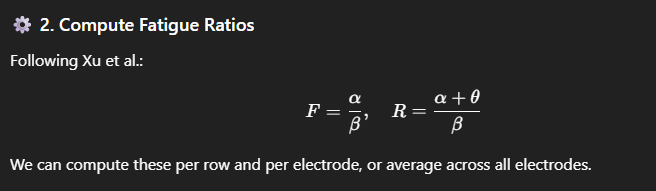



##Consider alpha, beta, gamma, and theta waves

θ (theta)
_4_8Hz__feat

α (alpha)
_8_12Hz__feat

β (beta)
_12_18Hz__feat

γ (gamma)
_25_32Hz__feat or _32_40Hz__feat

Fratio and r_ration are directly proportional to fatigue

In [ ]:
# ==============================================================
# 🧠 EEG Fatigue Index Computation (Xu et al., 2019 replication)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

fatigue_results = {}

for name, df in dataframes.items():
    print(f"\n🔍 Processing: {name}")

    # --- 1. Identify EEG band columns ---
    theta_cols = [c for c in df.columns if "_4_8Hz__feat" in c]
    alpha_cols = [c for c in df.columns if "_8_12Hz__feat" in c]
    beta_cols  = [c for c in df.columns if "_12_18Hz__feat" in c]

    if not (theta_cols and alpha_cols and beta_cols):
        print(f"⚠️ Missing required band columns in {name}. Skipping.")
        continue

    # --- 2. Compute average band power across all channels ---
    df['theta_mean'] = df[theta_cols].mean(axis=1)
    df['alpha_mean'] = df[alpha_cols].mean(axis=1)
    df['beta_mean']  = df[beta_cols].mean(axis=1)

    # --- 3. Compute fatigue indices (Xu et al.) ---
    df['F_ratio'] = df['alpha_mean'] / df['beta_mean']
    df['R_ratio'] = (df['alpha_mean'] + df['theta_mean']) / df['beta_mean']

    # --- 4. Optional: Normalize ratios for comparability ---
    df['F_norm'] = (df['F_ratio'] - df['F_ratio'].min()) / (df['F_ratio'].max() - df['F_ratio'].min())
    df['R_norm'] = (df['R_ratio'] - df['R_ratio'].min()) / (df['R_ratio'].max() - df['R_ratio'].min())

    # --- 5. Save updated dataframe ---
    dataframes[name] = df
    fatigue_results[name] = df[['latency_f__desc', 'F_ratio', 'R_ratio', 'F_norm', 'R_norm']]

    print(f"✅ Computed fatigue indices for {name} (rows: {len(df)})")

# ==============================================================
# 📊 Visualize fatigue evolution per session
# ==============================================================

for name, df in fatigue_results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(df['latency_f__desc'], df['R_ratio'], label='(α+θ)/β', color='orange')
    plt.plot(df['latency_f__desc'], df['F_ratio'], label='α/β', color='blue', alpha=0.7)
    plt.title(f"Fatigue Indices over Time — {name}")
    plt.xlabel("Latency (seconds or timestamp)")
    plt.ylabel("Fatigue Index Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Optional: display summary statistics for fatigue indices
for name, df in fatigue_results.items():
    print(f"\n📈 Summary for {name}")
    print(df[['F_ratio', 'R_ratio']].describe())


#Appending data

###Adding f ratio, r ratio, alpha, beta, theta, gamma as columns to the csvs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the base folder where processed files will be saved in Google Drive
base_drive_folder = '/content/drive/MyDrive/Processed_EEG_Data'

# ==============================================================
#   Add F_ratio and R_ratio columns to all EEG CSVs (Xu et al., 2019)
# ==============================================================

import numpy as np
import os

# Folder to save updated files (optional, to avoid overwriting originals)
output_folder = os.path.join(base_drive_folder, "EEG_with_fatigue_indices")
os.makedirs(output_folder, exist_ok=True)


for name, df in dataframes.items():
    print(f"\n⚙ Processing {name} ...")

    # --- Identify EEG band columns ---
    theta_cols = [c for c in df.columns if "_4_8Hz__feat" in c]
    alpha_cols = [c for c in df.columns if "_8_12Hz__feat" in c]
    beta_cols  = [c for c in df.columns if "_12_18Hz__feat" in c]

    if not (theta_cols and alpha_cols and beta_cols):
        print(f"⚠️ Missing some EEG bands in {name}, skipping.")
        continue

    # --- Compute average power for each frequency band ---
    df['theta_mean'] = df[theta_cols].mean(axis=1)
    df['alpha_mean'] = df[alpha_cols].mean(axis=1)
    df['beta_mean']  = df[beta_cols].mean(axis=1)

    # --- Compute fatigue indices ---
    df['F_ratio'] = df['alpha_mean'] / df['beta_mean']
    df['R_ratio'] = (df['alpha_mean'] + df['theta_mean']) / df['beta_mean']

    # --- Handle infinities or NaNs ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # --- Save updated CSV to Drive or local folder ---
    output_path = os.path.join(output_folder, name)
    df.to_csv(output_path, index=False)
    print(f"✅ Saved updated file: {output_path}")

print("\n⚒️ All CSVs processed and saved with new columns: F_ratio, R_ratio.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the base folder where processed files are located in Google Drive
base_drive_folder = '/content/drive/MyDrive/Processed_EEG_Data'

# ==============================================================
#   Convert UNIX timestamps → IST (naive, no +05:30)
# ==============================================================

import pandas as pd
import os

# Folder containing EEG CSVs with F_ratio, R_ratio
update_folder = os.path.join(base_drive_folder, "EEG_with_fatigue_indices")

# Loop through each CSV and add human-readable timestamps
for file_name in os.listdir(update_folder):
    if not file_name.lower().endswith(".csv"):
        continue

    file_path = os.path.join(update_folder, file_name)
    print(f"\n⏱️ Converting timestamps in: {file_name}")

    df = pd.read_csv(file_path)

    # Ensure both expected timestamp columns exist
    if "stamp_i__desc" not in df.columns or "stamp_f__desc" not in df.columns:
        print("  ⚠️ Missing timestamp columns — skipping.")
        continue

    # Convert UNIX seconds → IST naive datetime
    df["stamp_i__desc_human_readable"] = (
        pd.to_datetime(df["stamp_i__desc"], unit="s", utc=True)
        .dt.tz_convert("Asia/Kolkata")
        .dt.tz_localize(None)
    )

    df["stamp_f__desc_human_readable"] = (
        pd.to_datetime(df["stamp_f__desc"], unit="s", utc=True)
        .dt.tz_convert("Asia/Kolkata")
        .dt.tz_localize(None)
    )

    # Save back to same file (overwrite)
    df.to_csv(file_path, index=False)
    print(f"  ✅ Updated and saved: {file_name}")

print("\n⚒️ All EEG files now include IST (naive) human-readable timestamps.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the base folder where processed files are located in Google Drive
base_drive_folder = '/content/drive/MyDrive/Processed_EEG_Data'

# ==============================================================
# ⚡ Append Gamma Band Mean (25–40 Hz) to all EEG CSVs
# ==============================================================

import pandas as pd
import os
import numpy as np

eeg_folder = os.path.join(base_drive_folder, "EEG_with_fatigue_indices")

for file_name in os.listdir(eeg_folder):
    if not file_name.lower().endswith(".csv"):
        continue

    file_path = os.path.join(eeg_folder, file_name)
    print(f"\n⚙ Processing {file_name} for gamma_mean addition...")

    df = pd.read_csv(file_path)

    # --- Identify gamma band columns ---
    gamma_cols = [c for c in df.columns if ("_25_32Hz__feat" in c or "_32_40Hz__feat" in c)]

    if not gamma_cols:
        print("⚠️ No gamma band columns found — skipping.")
        continue

    # --- Compute gamma_mean ---
    df["gamma_mean"] = df[gamma_cols].mean(axis=1)

    # --- (Optional) normalize gamma_mean if you want comparability ---
    df["gamma_norm"] = (df["gamma_mean"] - df["gamma_mean"].min()) / (df["gamma_mean"].max() - df["gamma_mean"].min())

    # --- Save updated CSV (overwrite in place) ---
    df.to_csv(file_path, index=False)
    print(f"✅ gamma_mean and gamma_norm added to {file_name}")

print("\n⚒️ All EEG files updated with gamma_mean and gamma_norm columns.")

# KeyLogger Data Loading

In [ ]:
import io
import pandas as pd
from googleapiclient.http import MediaIoBaseDownload

# Keylogger folder ID from the provided URL
keylogger_folder_id = '1BmEK2zg-tz4tF8O715ahwzFSrS_4feTE'

# List files in the new keylogger folder
keylogger_results = service.files().list(
    q=f"'{keylogger_folder_id}' in parents",
    fields="files(id, name)").execute()
keylogger_files = keylogger_results.get('files', [])

if not keylogger_files:
    print('No keylogger files found in the specified folder.')
else:
    print('Keylogger Files Found:')
    for file in keylogger_files:
        print(f"{file.get('name')} ({file.get('id')})")

# Filter for CSV files
keylogger_csv_files = [file for file in keylogger_files if file.get('name', '').lower().endswith('.csv')]

if not keylogger_csv_files:
    print('No keylogger CSV files found.')
else:
    print('Keylogger CSV Files:')
    for file in keylogger_csv_files:
        print(f"{file.get('name')} ({file.get('id')})")

# Load keylogger CSV files into a dictionary of DataFrames
keylogger_dataframes = {}
for file in keylogger_csv_files:
  file_id = file['id']
  file_name = file['name']
  request = service.files().get_media(fileId=file_id)
  fh = io.BytesIO()
  downloader = MediaIoBaseDownload(fh, request)
  done = False
  while done is False:
    status, done = downloader.next_chunk()
    print(f"Downloading {file_name}: {int(status.progress() * 100)}%.")
  fh.seek(0)
  df = pd.read_csv(fh)
  keylogger_dataframes[file_name] = df
  print(f"Loaded {file_name} into a DataFrame.")

print("All keylogger CSV files loaded into keylogger_dataframes dictionary.")

---


# **Prepare DataFrames for Merging According to your discrepancies PLEASE AND TIME STAMP**


---



In [ ]:
eeg_df = dataframes['Pratham_P1_eeg_pre.csv']
keylog_df = keylogger_dataframes['Pratham_P1_keylog_pre.csv']

# Convert the 'Formatted_Timestamp' column in keylog_df to datetime objects
keylog_df['Formatted_Timestamp'] = pd.to_datetime(keylog_df['Formatted_Timestamp'])

print("Retrieved 'Pratham_P1_eeg_pre.csv' and 'Pratham_P1_keylog_pre.csv' DataFrames.")
print("Converted 'Formatted_Timestamp' in keylog_df to datetime objects.")

# Display info for verification
print("\nEEG DataFrame Info:")
eeg_df.info()
print("\nKeylogger DataFrame Info:")
keylog_df.info()

#FLOW

###
-Drop all records from keylogger csv prior to the first (updated keylog csv)

-use the unix Timestamp of first record on keylog csv to match it with the closest timestamp record in eeg csv

-adjust the offset in timestamps of keylog timestamp and stamp_i__desc in corresponding eeg csv

-Compute reaction time by creating a new column which has time difference of 2 successive records in keylog csv